In [ ]:
##This is the cleaned up code

In [120]:
from bs4 import BeautifulSoup
import requests
from requests import get

from IPython.core.display import display, HTML

In [121]:
response = get('https://sfbay.craigslist.org/d/apartments-housing-for-rent/search/sfc/apa?availabilityMode=0')

In [122]:
soup_cl2=BeautifulSoup(response.text, 'html.parser')

In [123]:
#to see how many total results in the Craigslist search for SF apartments
posts=soup_cl2.find_all('li', class_='result-row')
print(type(posts))
print(len(posts))

<class 'bs4.element.ResultSet'>
120


In [141]:
#this is the primary scrape of the results
from bs4 import BeautifulSoup
import requests
from requests import get

from IPython.core.display import display, HTML

from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

#find the total number of posts to find the limit of the pagination
results_num = soup_cl2.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array
print("the total number of results is ", results_total)

#each page has 119 posts so each new page is defined: s=120, s=240, s=360, and so on. Step size 120 in the np.arange function
pages = np.arange(0, results_total+1, 120)
print("The range of numbers for the pages is ", pages)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []

for page in pages:
    
    #get request
    url="https://sfbay.craigslist.org/d/apartments-housing-for-rent/search/sfc/apa?" + "s="+ str(page) + "&availabilityMode=0"
    #the parameter for defining the page number 
    #into s= put the page number in the pages array from earlier
    
    print(url) #check to make sure it's stepping through the results pages ok
    response = get(url)

    sleep(randint(1,5)) 
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #Here is the problem with the primary scrape, and why it kept scaping the first page repeatedly!! 
    #when I copy-pasted code from above to go thru the urls, I pasted soup_cl2
    #and not page_html, which is the next page in this code block. This is why it kept scraping the first
    #page of results repeatedly.
    posts = page_html.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            post_price = post.a.text.strip().replace(",", "").replace("$", "")  #split()[0]  #strip().replace("$", "")
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is square footage, this means that it's a studio, i.e., 0 bedrooms
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                        
                    #If the unit is a studio, no bedroom number will appear in the listing results. 
                    #However, listers must indicate number of bedrooms even if it is 0 (i.e., a studio) 
                    #Need to make the bedroom count 0 if it's a studio 
                    bedroom_count = "0"
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    #again here I need to make the bedroom count 0 if there is no number in the
                    #housing details element, because that means it is a studio.
                    bedroom_count = "0"
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                
                #again here I need to make the bedroom count 0 if there is no number in the housing
                #details element, because that indicates the listing is a studio.
                bedroom_count = "0"
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            
                
    iterations += 1
    print("Page " + str(iterations) + " scraped")

print("\n")

print("Scrape complete")

the total number of results is  3000
The range of numbers for the pages is  [   0  120  240  360  480  600  720  840  960 1080 1200 1320 1440 1560
 1680 1800 1920 2040 2160 2280 2400 2520 2640 2760 2880 3000]
https://sfbay.craigslist.org/d/apartments-housing-for-rent/search/sfc/apa?s=0&availabilityMode=0
Page 1 scraped
https://sfbay.craigslist.org/d/apartments-housing-for-rent/search/sfc/apa?s=120&availabilityMode=0
Page 2 scraped
https://sfbay.craigslist.org/d/apartments-housing-for-rent/search/sfc/apa?s=240&availabilityMode=0
Page 3 scraped
https://sfbay.craigslist.org/d/apartments-housing-for-rent/search/sfc/apa?s=360&availabilityMode=0
Page 4 scraped
https://sfbay.craigslist.org/d/apartments-housing-for-rent/search/sfc/apa?s=480&availabilityMode=0
Page 5 scraped
https://sfbay.craigslist.org/d/apartments-housing-for-rent/search/sfc/apa?s=600&availabilityMode=0
Page 6 scraped
https://sfbay.craigslist.org/d/apartments-housing-for-rent/search/sfc/apa?s=720&availabilityMode=0
Page 7 scr

In [142]:
#print (post_links) This was a check to see if the links scraped repeated or not

In [187]:
import pandas as pd

sf_apts = pd.DataFrame({'posted': post_timing,
                       'neighborhood': post_hoods,
                       'post title': post_title_texts,
                       'number bedrooms': bedroom_counts,
                        'sqft': sqfts,
                        'URL': post_links,
                       'price': post_prices})
        
#sf_apts = pd.DataFrame({'URL': post_links})  <--used to try to see the entire URLs in the dataframe
#drop row index 108, that post was flagged for removal and the scraper choked on it.
sf_apts.drop(index=108, inplace=True)
print(sf_apts.info())
sf_apts.head(111)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2982 entries, 0 to 2982
Data columns (total 7 columns):
posted             2982 non-null object
neighborhood       2982 non-null object
post title         2982 non-null object
number bedrooms    2982 non-null object
sqft               1410 non-null float64
URL                2982 non-null object
price              2982 non-null object
dtypes: float64(1), object(6)
memory usage: 186.4+ KB
None


,posted,neighborhood,post title,number bedrooms,sqft,URL,price
0,2021-01-24 13:06,(marina / cow hollow),Top Floor 1 Bedroom Corner Apartment in the Ma...,1,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3000
1,2021-01-24 13:06,(noe valley),Spacious entire 5Br/2Ba house close to 24th St.,5,1950.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,7500
2,2021-01-24 13:06,(castro / upper market),Dolores Park Top Floor Studio with a Downtown ...,0,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2000
3,2021-01-24 13:04,(marina / cow hollow),2nd Floor 1 Bedroom in the Marina District!,1,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2900
4,2021-01-24 13:04,(castro / upper market),Sunny Dolores Heights Studio Apartment!,0,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,1900
...,...,...,...,...,...,...,...
106,2021-01-24 12:05,(russian hill),"Russian Hill 1br near Ghirardelli Square, lndr...",1,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2300
107,2021-01-24 12:05,(hayes valley),Looking for a studio? This is the one! Spaciou...,0,550.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2500
109,2021-01-24 12:01,(nob hill),"Beautiful Penthouse Nob Hill Condo w/ Parking,...",3,2000.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,6400
110,2021-01-24 12:00,(alamo square / nopa),*LOVELY APT *2nd Fl *Quiet *DW / Granite *Hwd...,1,600.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2750


In [191]:
#take index#108 from post_links because it's flagged
post_links.pop(108)

'https://sfbay.craigslist.org/sfc/apa/d/san-francisco-lovely-1bed-1bath-with/7267136493.html'

In [188]:
#write dataframe to csv file, with the offending row removed
sf_apts.to_csv('ALS_proj2C_20210124.csv')

In [194]:
#write function for the secondary scrape. It works but  needs nan values for empty list places
##This is the current working function for the secondary scrape

bath_counts = []


for url in post_links:
    #get request
    #print(url)
    response = get(url)
    sleep(randint(1,5))
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page2=response.text
    soup2=BeautifulSoup(page2, 'lxml')
    
    #this is the block that works on a single url
    try:
        bath_count = soup2.find('span', class_ = 'shared-line-bubble').text.split()[2]  #replace("BR", "") #.split()[0]
        bath_count = bath_count.replace("Ba", "")
    #bath_count = float(bath_count)
        bath_counts.append(bath_count)
    ##Yay I got the bath counts to be a float! No, it choked. I'll have to do it in the dataframe.
    
    #getting a lot of AttributeErrors from flagged posts! Need to add some error handling.
    except AttributeError:
        bath_counts.append("AttributeError")

#I can get the bedroom counts from the initial scrape, only need bath counts from this scrape


    #print("bathrooms ", bath_counts)
    #print("data type number bathrooms ", type(bath_counts)) 
    #print("data type bath_count ", type(bath_count))

In [200]:
import pandas as pd

sf_apts_3 = pd.DataFrame({'URL': post_links,
                        'number bathrooms': bath_counts
                         })
        
##the scraping choked on record index #108. I checked, and this post was flagged for removal. 
##I need to drop the row with index 108 using df.drop([]), above
##Then I added error handling for the AttributeError that kept coming up if a post was flagged for removal.
##That way, I didn't have to remove a row every time the scrape choked on a flagged post.

###Some diagnostic dataframes and print statements below

#sf_apts_url = pd.DataFrame({'URL': post_links})
#sf_apts_bathrooms = pd.DataFrame({'number bathrooms': bath_counts})
    
#sf_apts = pd.DataFrame({'URL': post_links})
#print(sf_apts_url.info())
#sf_apts_url.head(10)
#print(sf_apts_bathrooms.info())   
#sf_apts_bathrooms.head(10)

print(sf_apts_3.info())
sf_apts_3.head(150)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2982 entries, 0 to 2981
Data columns (total 2 columns):
URL                 2982 non-null object
number bathrooms    2982 non-null object
dtypes: object(2)
memory usage: 46.7+ KB
None


,URL,number bathrooms
0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,1
1,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2
2,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,1
3,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,1
4,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,1
...,...,...
145,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2
146,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,1
147,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,1
148,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,1


In [180]:
#sf_apts_bathrooms.to_csv('ALS_proj2_troubshoot_baths_20210124.csv')

In [196]:
#write dataframe to csv file
sf_apts_3.to_csv('ALS_proj2C_baths_20210124.csv')

In [201]:
sf_apts_4 = pd.DataFrame({'URL': post_links,
                       'neighborhood': post_hoods,
                       'post title': post_title_texts,
                       'number bedrooms': bedroom_counts,
                       'number bathrooms': bath_counts,
                       'sqft': sqfts,
                       'price': post_prices})
        
#Join the first scrape with the list of bathroom numbers 
#Actually need to join the first dataframe with index row 108 removed to the list of bathroom counts.
print(sf_apts_4.info())
sf_apts_4.head(10)

ValueError: arrays must all be same length

In [ ]:
##I changed the post_links array to remove row 108 above, but didn't change the other arrays.
##I would need to go back and do that to the other arrays in the dataframe, so that
##all arrays are the same length.

In [ ]:
##The scraping and error handling is fixed. I did not repeat the cleaning and analysis on 
##the new dataset.
###Everything below is from the previous scrape before I fixed the problems above.

In [35]:
#write dataframe to csv file
sf_apts_3.to_csv('ALS_proj2_all_included_20210121.csv')

In [38]:
#In'number bedrooms' column, convert NaNs to zeroes, as these are studio apartments
sf_apts_3['number bedrooms'] = sf_apts_3['number bedrooms'].fillna(0)

In [39]:
#check to see if NaNs changed
print(sf_apts_3.info())
sf_apts_3.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3068 entries, 0 to 3067
Data columns (total 8 columns):
URL                 3068 non-null object
posted              3068 non-null object
neighborhood        3068 non-null object
post title          3068 non-null object
number bedrooms     3068 non-null object
number bathrooms    3068 non-null object
sqft                1430 non-null float64
price               3068 non-null object
dtypes: float64(1), object(7)
memory usage: 191.9+ KB
None


,URL,posted,neighborhood,post title,number bedrooms,number bathrooms,sqft,price
0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:25,(lower nob hill),Beautiful one bedroom in great Lower Nob Hill ...,1,1,NaN,2200
1,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:19,(mission district),EFFECTIVE RENT $1450 UTILITIES ALL INCLUDED.,0,1,240.0,1450
2,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:19,(USF / panhandle),Large Studio Two blocks from USF Lone Mountain,0,1,NaN,2150
3,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:18,(USF / panhandle),Large Studio Two blocks from USF Lone Mountain,0,1,NaN,1950
4,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:18,(USF / panhandle),Spacious 2 Bedroom 2 blocks from USF Lone Moun...,2,1,NaN,3400
5,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:18,(USF / panhandle),Spacious 2 Bedroom 2 blocks from USF Lone Moun...,2,1,NaN,3250
6,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:16,(castro / upper market),Charming One Bedroom With Garden View In Castr...,1,1,NaN,2495
7,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:12,(inner richmond),quiet 2 bedroom apt facing garden,2,1,800.0,3200
8,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:12,(lower nob hill),Centrally located 3 bedroom flat,3,1.5,1100.0,4200
9,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:12,(SOMA / south beach),"One Rincon Hill, 1BR 1BA with Parking & Views",1,1,605.0,3150


In [40]:
#remove whitespaces from 'price' data
sf_apts_3['price'].str.strip()

0       2200
1       1450
2       2150
3       1950
4       3400
        ... 
3063    3000
3064    1995
3065    2595
3066    1200
3067    2000
Name: price, Length: 3068, dtype: object

In [41]:
#remove whitespaces from 'number bedrooms' data
sf_apts_3['number bedrooms'].str.strip()

0         1
1       NaN
2       NaN
3       NaN
4         2
       ... 
3063      1
3064    NaN
3065      1
3066      1
3067      2
Name: number bedrooms, Length: 3068, dtype: object

In [42]:
#remove whitespaces from 'number bathrooms' data
sf_apts_3['number bathrooms'].str.strip()

0         1
1         1
2         1
3         1
4         1
       ... 
3063      1
3064      1
3065      1
3066    1.5
3067      1
Name: number bathrooms, Length: 3068, dtype: object

In [44]:
#convert 'price' data to int type (or numeric type)
#sf_apts_3['price'].astype(int)  not working. ValueError '' invalid literal
sf_apts_3['price'] = pd.to_numeric(sf_apts_3['price'])

In [45]:
#check data type of 'price' column
print(sf_apts_3.info())
sf_apts_3.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3068 entries, 0 to 3067
Data columns (total 8 columns):
URL                 3068 non-null object
posted              3068 non-null object
neighborhood        3068 non-null object
post title          3068 non-null object
number bedrooms     3068 non-null object
number bathrooms    3068 non-null object
sqft                1430 non-null float64
price               2990 non-null float64
dtypes: float64(2), object(6)
memory usage: 191.9+ KB
None


,URL,posted,neighborhood,post title,number bedrooms,number bathrooms,sqft,price
0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:25,(lower nob hill),Beautiful one bedroom in great Lower Nob Hill ...,1,1,NaN,2200.0
1,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:19,(mission district),EFFECTIVE RENT $1450 UTILITIES ALL INCLUDED.,0,1,240.0,1450.0
2,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:19,(USF / panhandle),Large Studio Two blocks from USF Lone Mountain,0,1,NaN,2150.0
3,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:18,(USF / panhandle),Large Studio Two blocks from USF Lone Mountain,0,1,NaN,1950.0
4,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:18,(USF / panhandle),Spacious 2 Bedroom 2 blocks from USF Lone Moun...,2,1,NaN,3400.0
5,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:18,(USF / panhandle),Spacious 2 Bedroom 2 blocks from USF Lone Moun...,2,1,NaN,3250.0
6,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:16,(castro / upper market),Charming One Bedroom With Garden View In Castr...,1,1,NaN,2495.0
7,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:12,(inner richmond),quiet 2 bedroom apt facing garden,2,1,800.0,3200.0
8,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:12,(lower nob hill),Centrally located 3 bedroom flat,3,1.5,1100.0,4200.0
9,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:12,(SOMA / south beach),"One Rincon Hill, 1BR 1BA with Parking & Views",1,1,605.0,3150.0


In [47]:
#convert 'number bedrooms' and 'number bathrooms' data to int type (or float type)
sf_apts_3['number bedrooms'] = pd.to_numeric(sf_apts_3['number bedrooms'])
#sf_apts_3['number bathrooms'] = pd.to_numeric(sf_apts_3['number bathrooms']) not working

In [48]:
#check data type of 'number bedrooms' column
print(sf_apts_3.info())
sf_apts_3.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3068 entries, 0 to 3067
Data columns (total 8 columns):
URL                 3068 non-null object
posted              3068 non-null object
neighborhood        3068 non-null object
post title          3068 non-null object
number bedrooms     3068 non-null int64
number bathrooms    3068 non-null object
sqft                1430 non-null float64
price               2990 non-null float64
dtypes: float64(2), int64(1), object(5)
memory usage: 191.9+ KB
None


,URL,posted,neighborhood,post title,number bedrooms,number bathrooms,sqft,price
0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:25,(lower nob hill),Beautiful one bedroom in great Lower Nob Hill ...,1,1,NaN,2200.0
1,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:19,(mission district),EFFECTIVE RENT $1450 UTILITIES ALL INCLUDED.,0,1,240.0,1450.0
2,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:19,(USF / panhandle),Large Studio Two blocks from USF Lone Mountain,0,1,NaN,2150.0
3,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:18,(USF / panhandle),Large Studio Two blocks from USF Lone Mountain,0,1,NaN,1950.0
4,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:18,(USF / panhandle),Spacious 2 Bedroom 2 blocks from USF Lone Moun...,2,1,NaN,3400.0
5,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:18,(USF / panhandle),Spacious 2 Bedroom 2 blocks from USF Lone Moun...,2,1,NaN,3250.0
6,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:16,(castro / upper market),Charming One Bedroom With Garden View In Castr...,1,1,NaN,2495.0
7,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:12,(inner richmond),quiet 2 bedroom apt facing garden,2,1,800.0,3200.0
8,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:12,(lower nob hill),Centrally located 3 bedroom flat,3,1.5,1100.0,4200.0
9,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:12,(SOMA / south beach),"One Rincon Hill, 1BR 1BA with Parking & Views",1,1,605.0,3150.0


In [51]:
#write dataframe to csv file
sf_apts_3.to_csv('ALS_proj2_all_but_ba_converted_20210121.csv')

In [52]:
#Great! Bedrooms, sq ft, and price are all numeric data types now.
#Still need to figure out what's going on with with bathrooms. Need to be numeric
#sf_apts_3['number bathrooms'] = sf_apts_3['number bathrooms'].astype(float)
#looks like two of the choices are strings: 'shared' and 'split'. 
#Maybe I can convert these to 0.5 (for split) and 0.25 (for shared) and then change type
sf_apts_3['number bathrooms'].replace({'split': '0.5', 'shared': '0.25'}, inplace=True)

In [53]:
#seemed to work. Try changing the type of that column again.
sf_apts_3['number bathrooms'] = sf_apts_3['number bathrooms'].astype(float)

In [54]:
#So far so good. Check the dataframe.
print(sf_apts_3.info())
sf_apts_3.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3068 entries, 0 to 3067
Data columns (total 8 columns):
URL                 3068 non-null object
posted              3068 non-null object
neighborhood        3068 non-null object
post title          3068 non-null object
number bedrooms     3068 non-null int64
number bathrooms    3068 non-null float64
sqft                1430 non-null float64
price               2990 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 191.9+ KB
None


,URL,posted,neighborhood,post title,number bedrooms,number bathrooms,sqft,price
0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:25,(lower nob hill),Beautiful one bedroom in great Lower Nob Hill ...,1,1.0,NaN,2200.0
1,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:19,(mission district),EFFECTIVE RENT $1450 UTILITIES ALL INCLUDED.,0,1.0,240.0,1450.0
2,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:19,(USF / panhandle),Large Studio Two blocks from USF Lone Mountain,0,1.0,NaN,2150.0
3,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:18,(USF / panhandle),Large Studio Two blocks from USF Lone Mountain,0,1.0,NaN,1950.0
4,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:18,(USF / panhandle),Spacious 2 Bedroom 2 blocks from USF Lone Moun...,2,1.0,NaN,3400.0
5,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:18,(USF / panhandle),Spacious 2 Bedroom 2 blocks from USF Lone Moun...,2,1.0,NaN,3250.0
6,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:16,(castro / upper market),Charming One Bedroom With Garden View In Castr...,1,1.0,NaN,2495.0
7,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:12,(inner richmond),quiet 2 bedroom apt facing garden,2,1.0,800.0,3200.0
8,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:12,(lower nob hill),Centrally located 3 bedroom flat,3,1.5,1100.0,4200.0
9,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2021-01-21 00:12,(SOMA / south beach),"One Rincon Hill, 1BR 1BA with Parking & Views",1,1.0,605.0,3150.0


In [55]:
#looks like it worked. Now write dataframe to csv file so we preserve all the datatypes
sf_apts_3.to_csv('ALS_proj2_ALL_data_types_converted_20210121.csv')

In [57]:
import random
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [63]:
sf_apts_3_hue_df=pd.read_csv('ALS_proj2_ALL_dtc_bed_bath_nhood_20210121.csv')

In [64]:
print(sf_apts_3_hue_df.info())
sf_apts_3_hue_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3068 entries, 0 to 3067
Data columns (total 5 columns):
Unnamed: 0          3068 non-null int64
neighborhood        3068 non-null object
number bedrooms     3068 non-null int64
number bathrooms    3068 non-null float64
price               2990 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 120.0+ KB
None


,Unnamed: 0,neighborhood,number bedrooms,number bathrooms,price
0,0,(lower nob hill),1,1.0,2200.0
1,1,(mission district),0,1.0,1450.0
2,2,(USF / panhandle),0,1.0,2150.0
3,3,(USF / panhandle),0,1.0,1950.0
4,4,(USF / panhandle),2,1.0,3400.0
5,5,(USF / panhandle),2,1.0,3250.0
6,6,(castro / upper market),1,1.0,2495.0
7,7,(inner richmond),2,1.0,3200.0
8,8,(lower nob hill),3,1.5,4200.0
9,9,(SOMA / south beach),1,1.0,3150.0


/Users/amysillman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/amysillman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/amysillman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/amysillman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


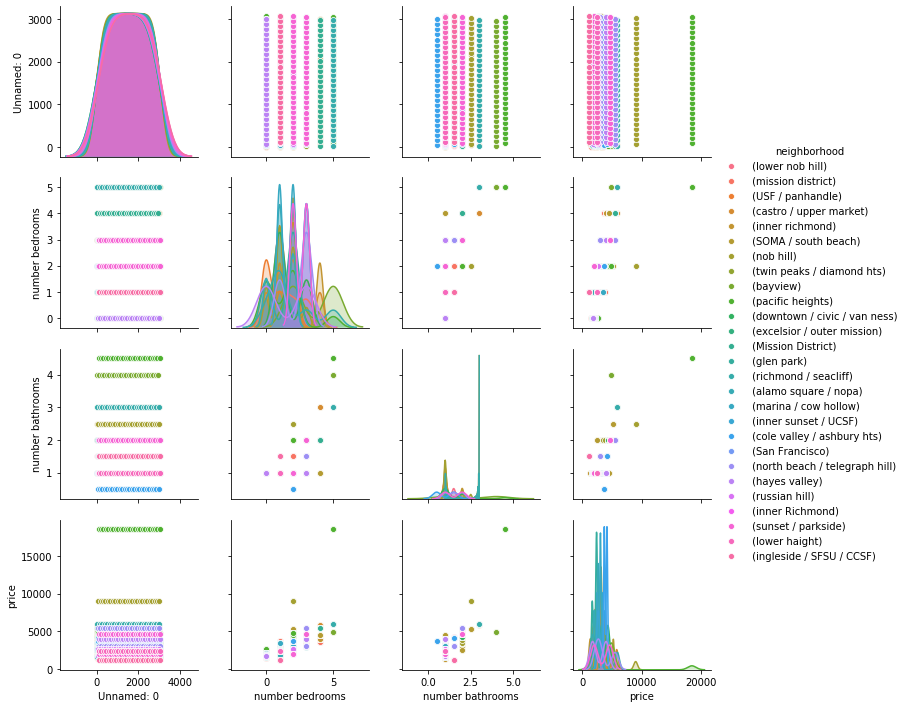

In [65]:
#can't do pairplot with categorical data, but can do a hue pairplot with neighborhoods color coded
sns.pairplot(sf_apts_3_hue_df, hue = 'neighborhood')

In [ ]:
#This looks bizarre. There is one very high rent that's represented multiple times.
#This must be a duplicate. I looked at the csv file after this, and after seeing that 
#many records have no rent listed. So I eliminated duplicates and records w/o rent.
#This leaves 115 unique records. It looks like I only scraped the first page of results  
#multiple times. Something is wrong with the way it stepped through the results pages.

In [73]:
df_new = pd.read_csv('ALS_proj2_ALL_data_types_converted_BRBARent_only_nodup_20210121.csv')
print(df_new.info())
df_new.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
Unnamed: 0          114 non-null int64
neighborhood        114 non-null object
number bedrooms     114 non-null int64
number bathrooms    114 non-null float64
price               114 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 4.6+ KB
None


,Unnamed: 0,neighborhood,number bedrooms,number bathrooms,price
0,0,(lower nob hill),1,1.0,2200
1,1,(mission district),0,1.0,1450
2,2,(USF / panhandle),0,1.0,2150
3,3,(USF / panhandle),0,1.0,1950
4,4,(USF / panhandle),2,1.0,3400
5,5,(USF / panhandle),2,1.0,3250
6,6,(castro / upper market),1,1.0,2495
7,7,(inner richmond),2,1.0,3200
8,8,(lower nob hill),3,1.5,4200
9,9,(SOMA / south beach),1,1.0,3150


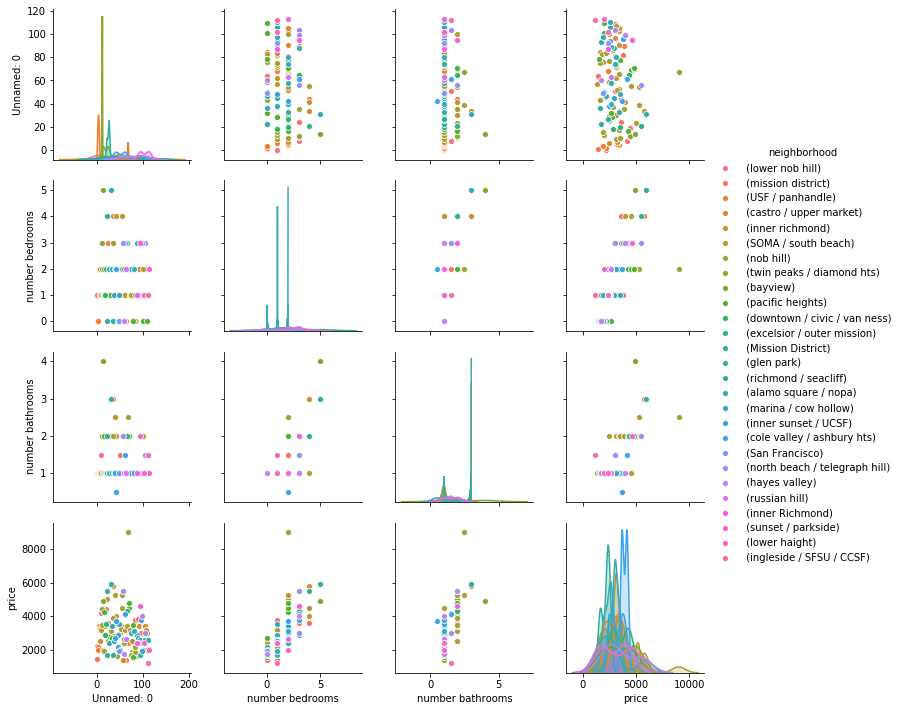

In [74]:
#Try the pairplot again
sns.pairplot(df_new, hue = 'neighborhood')

In [75]:
df_new_sqft = pd.read_csv('ALS_proj2_dtypes_converted_nodup_nnrentsqft_nodesc_20210121.csv')
print(df_new_sqft.info())
df_new_sqft.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404 entries, 0 to 1403
Data columns (total 6 columns):
Unnamed: 0          54 non-null float64
neighborhood        54 non-null object
number bedrooms     54 non-null float64
number bathrooms    54 non-null float64
sqft                54 non-null float64
price               54 non-null float64
dtypes: float64(5), object(1)
memory usage: 65.9+ KB
None


,Unnamed: 0,neighborhood,number bedrooms,number bathrooms,sqft,price
0,0.0,(mission district),0.0,1.0,240.0,1450.0
1,1.0,(SOMA / south beach),1.0,1.0,605.0,3150.0
2,2.0,(inner richmond),2.0,1.0,800.0,3200.0
3,3.0,(lower nob hill),3.0,1.5,1100.0,4200.0
4,4.0,(twin peaks / diamond hts),3.0,2.0,1800.0,4450.0
5,5.0,(twin peaks / diamond hts),3.0,2.0,1800.0,4450.0
6,6.0,(nob hill),1.0,1.0,693.0,2000.0
7,7.0,(nob hill),1.0,1.0,675.0,1900.0
8,8.0,(pacific heights),2.0,2.0,1850.0,4250.0
9,9.0,(SOMA / south beach),2.0,2.0,884.0,3396.0


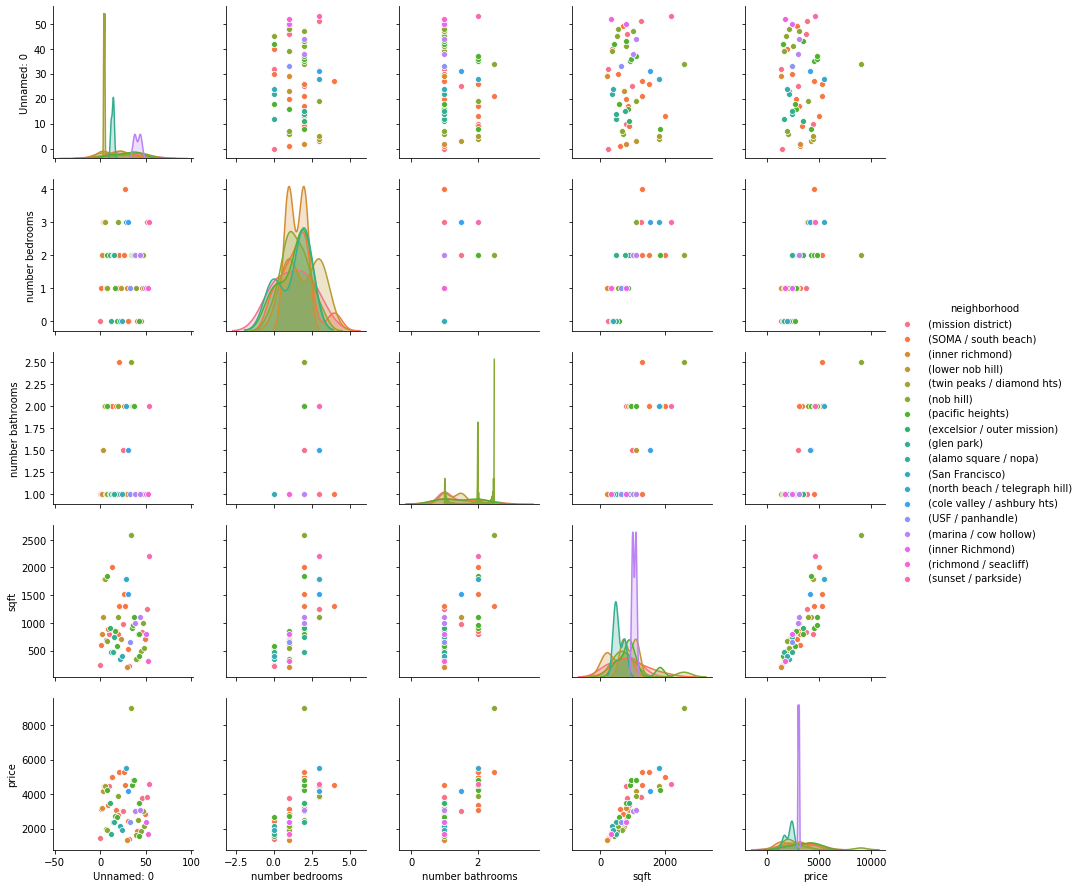

In [76]:
#pairplot including records w sq ft info
sns.pairplot(df_new_sqft, hue = 'neighborhood')

In [80]:
df_num_only = pd.read_csv('ALS_proj2_dtypes_converted_nodup_numbers_only_20210121.csv')
print(df_num_only.info())
df_num_only.head(10)

#the linear regression doesn't like having 'neighborhood' so new df with only numerical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
Unnamed: 0          54 non-null int64
number bedrooms     54 non-null int64
number bathrooms    54 non-null float64
sqft                54 non-null int64
price               54 non-null int64
dtypes: float64(1), int64(4)
memory usage: 2.2 KB
None


,Unnamed: 0,number bedrooms,number bathrooms,sqft,price
0,0,0,1.0,240,1450
1,1,1,1.0,605,3150
2,2,2,1.0,800,3200
3,3,3,1.5,1100,4200
4,4,3,2.0,1800,4450
5,5,3,2.0,1800,4450
6,6,1,1.0,693,2000
7,7,1,1.0,675,1900
8,8,2,2.0,1850,4250
9,9,2,2.0,884,3396


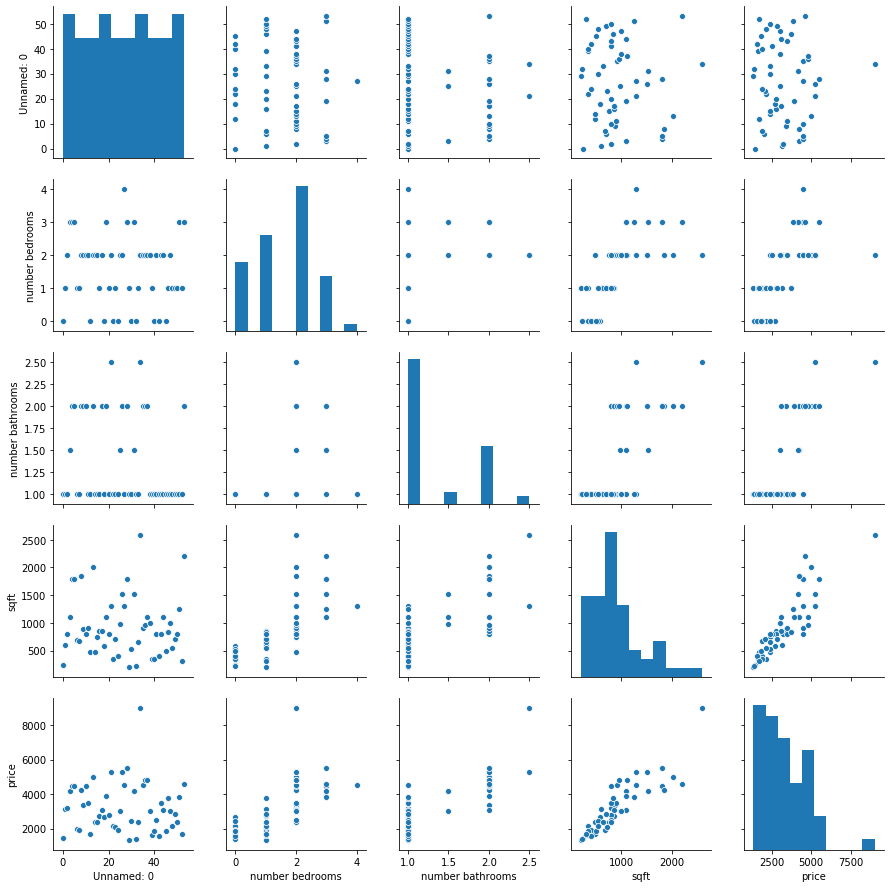

In [84]:
#pairplot including records w sq ft info
sns.pairplot(df_num_only)

In [114]:
#df = pd.read_csv('ALS_proj2_ALL_data_types_converted_nnrent_nodup_20210121')
x_train, x_test, y_train, y_test = train_test_split(df_num_only[['number bedrooms']], df_num_only['price'], test_size=0.33, random_state=42)
m = LinearRegression()
m.fit(x_train,y_train)
m.score(x_train,y_train)
print('the training score for number of bedrooms is ', m.score(x_train,y_train))
m.score(x_test,y_test)
print('the test score for number of bedrooms is ', m.score(x_test,y_test))

the training score for number of bedrooms is  0.5488311264641899
the test score for number of bedrooms is  0.29436757622009935


In [119]:
#df = pd.read_csv('ALS_proj2_ALL_data_types_converted_nnrent_nodup_20210121')
x_train, x_test, y_train, y_test = train_test_split(df_num_only[['sqft']], df_num_only['price'], test_size=0.33, random_state=42)
m = LinearRegression()
m.fit(x_train,y_train)
m.score(x_train,y_train)
print('the score for training square footage is ', m.score(x_train,y_train))
print(m.coef_)
m.score(x_test,y_test)
print('the score for the test square footage is ', m.score(x_test,y_test))

the score for training square footage is  0.6617818108363493
[2.16486124]
the score for the test square footage is  0.816051367878765


In [118]:
#Square footage is a better predictor. Can we make the model fit better? 
#It looks logarithmic! new variable, x1
import math
df_num_only['x1']= np.log(df_num_only['sqft'])
x_train, x_test, y_train, y_test = train_test_split(df_num_only[['x1']], df_num_only['price'], test_size=0.33, random_state=42)
m = LinearRegression()
m.fit(x_train,y_train)
m.score(x_train,y_train)
print(m.coef_)
m.score(x_test,y_test)
print('the score for log of the training sqft data is ', m.score(x_train,y_train))
print('the score for the log of the test sqft data is ', m.score(x_test,y_test) )

[1777.46716553]
the score for log of the training sqft data is  0.6866397400172419
the score for the log of the test sqft data is  0.6873145573430646


In [92]:
#that's better! Test on test data
m.score(x_test,y_test)
print('the score for the log of the test sqft data is ', m.score(x_test,y_test) )

the score for the log of the test sqft data is  0.6873145573430646


In [116]:
m.coef_

array([1777.46716553])

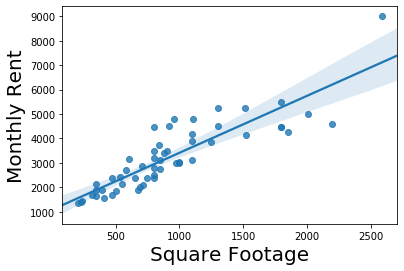

In [109]:
#sns.set_theme(color_codes=True)
sns.regplot(x="sqft", y="price", data=df_num_only);
plt.xlabel("Square Footage", size=20)
plt.ylabel("Monthly Rent", size=20)
plt.savefig("sqft_linear.png")

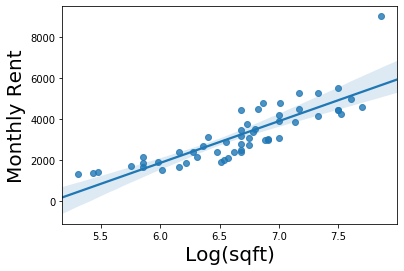

In [110]:
sns.regplot(x='x1', y='price',data=df_num_only );
plt.xlabel("Log(sqft)", size=20)
plt.ylabel("Monthly Rent", size=20)
plt.savefig("sqft_log.png")

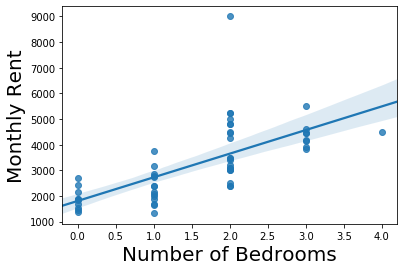

In [111]:
sns.regplot(x="number bedrooms", y="price", data=df_num_only);
plt.xlabel("Number of Bedrooms", size=20)
plt.ylabel("Monthly Rent", size=20)
plt.savefig("bedrooms_linear.png")